In [1]:
from model import atp_graph, losses
from Tutorials.helper import batcher
from data import synthetic_data_gen, feature_extractor
import keras
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import pandas as pd
import tensorflow as tf
import IPython
import time
import os

from model import atp_pipeline

In [6]:
pd_array = pd.read_csv('datasets/traffic.csv')

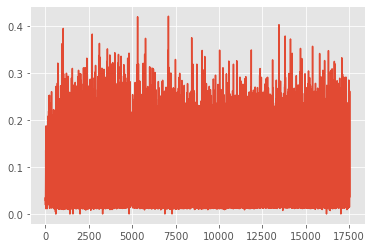

In [17]:
plt.plot(pd_array['2'])

In [7]:
data = np.array(pd_array)

In [9]:
data[:,0] = np.linspace(-1,1,data.shape[0])

In [10]:
data = data.astype("float32")

In [12]:
training_data = data[:int(0.7*data.shape[0])]
val_data = data[int(0.7*data.shape[0]):int(0.8*data.shape[0])]
test_data = data[int(0.9*data.shape[0]):]

In [13]:
#scale

training_data_scaled = (training_data - np.mean(training_data,axis=0))/np.std(training_data,axis=0)
val_data_scaled = (val_data - np.mean(training_data,axis=0))/np.std(training_data,axis=0)
test_data_scaled =  (test_data - np.mean(training_data,axis=0))/np.std(training_data,axis=0)

In [14]:
save_dir = "weights/forecasting/traffic"

In [ ]:
tf.random.set_seed(442)
opt = tf.keras.optimizers.Adam(3e-4)
run=3; heads=2
atp_model = atp_pipeline.atp_pipeline()
EPOCHS = 2

In [15]:
seq_l = 96+192;
num_batches = 500
batch_s=20
mini = 50000
n_C_te =5

In [ ]:
step = 1
tr_step = atp_graph.build_graph()

name_comp = 'run_' + str(run)
logdir = save_dir + '/logs/' + name_comp
folder = save_dir + '/ckpt/check_' + name_comp

if not os.path.exists(folder): os.mkdir(folder)
ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=opt, net=atp_model)
manager = tf.train.CheckpointManager(ckpt, folder, max_to_keep=1)
ckpt.restore(manager.latest_checkpoint)

In [ ]:
for epoch in range(2):
    print("epoch: ",+epoch)
    start = time.time()
    for batch_n in range(10):
         
        x,y = batcher(training_data_scaled[:,:1],training_data_scaled[:,-2:])
        n_C = int(np.random.choice(np.arange(2, 20), 1))
        n_T = 288 - n_C
        y_tr = y
        t_tr = x
        _,_, nll_pp, msex = tr_step(atp_model, opt, t_tr,y_tr,n_C,n_T, training=True)

        if ((batch_n % 2 == 0)):
            
            n_C = 10
            n_T = 200 - n_C
            t_te,y_te = batcher(val_data_scaled[:,:1], val_data_scaled[:,-2:],batch_s = 100)
            μ, log_σ = atp_model([t_te, y_te, 10, 200, False])
            _,_,_, nll_pp_te, msex_te = losses.nll(y_te[:, n_C:n_C+n_T], μ[:, n_C:], log_σ[:, n_C:])
            
        if nll_pp_te < mini:
            mini = nll_pp_te
            IPython.display.clear_output(wait=True)
            print("epoch {} batch {} validation lik pp: {}".format(epoch, batch_n, nll_pp)) 
            manager.save()
            step += 1
            ckpt.step.assign_add(1)
    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))